# Introduction

Read in data here

In [87]:
import os
import gymnasium as gym
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Custom Observation Wrapper ---
class CustomFlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # We assume we only care about the "image" component of the dict observation
        image_space = env.observation_space.spaces["image"]
        self.observation_space = gym.spaces.Box(
            low=image_space.low.flatten(),
            high=image_space.high.flatten(),
            dtype=image_space.dtype
        )

    def observation(self, obs):
        return obs["image"].flatten()

# --- Load Trained Models ---
seed = 0
env_name = 'MiniGrid-DoorKey-5x5-v0'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = CustomFlattenObservation(env)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/minigrid/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

In [88]:
import numpy as np
import torch
from minigrid_test import make_env  # Replace with correct import path if needed


# Create environment to generate states
env_name = "DoorKey-5x5"  # Adjust based on your env_name
env = make_env(env_name, train=False)
env.reset(seed=seed)
H, W = env.unwrapped.height, env.unwrapped.width  # Get grid dimensions

# 1. Gather all states and their embeddings
all_states = []
coords = []  # To track state positions for reference
for r in range(H):
    for c in range(W):
        # Place the agent at (r, c), direction = 0
        env.unwrapped.agent_pos = (r, c)
        env.unwrapped.agent_dir = 0

        # Get observation from environment
        obs = env.unwrapped.gen_obs()  # Returns a dict with 'image', 'direction', 'mission'
        flattened_obs = obs["image"].flatten()

        # Convert to tensor and get state embedding using the model's features_extractor
        state_t = torch.tensor(flattened_obs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features_pi, features_vf = model.policy.mlp_extractor(state_t)
            state_embedding = features_pi.cpu().numpy().squeeze()  # Remove batch dimension

        all_states.append(state_embedding)
        coords.append((r, c))

# Convert to numpy array
state_embeddings = np.array(all_states)
print("State Embeddings Shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)


State Embeddings Shape: (25, 128)
Action Embeddings Shape: (7, 128)


(128,) (7, 128)


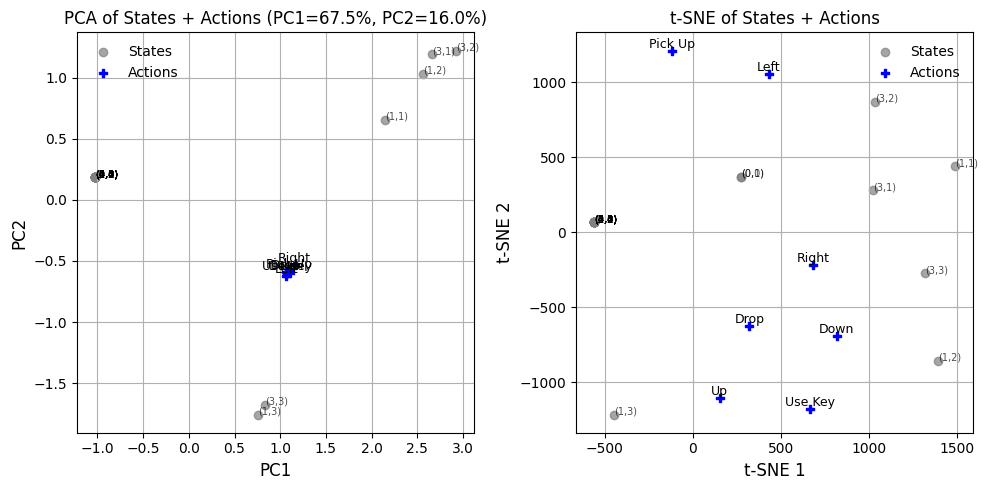

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


print(state_embedding.shape, action_embeddings.shape)

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# Action labels (assuming 7 actions)
action_labels = ["Left", "Right", "Down", "Up", "Pick Up", "Use Key", "Drop"]  # Adjust if needed

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
for i, (r, c) in enumerate(coords):
    x, y = pca_states[i]
    plt.annotate(f"({r},{c})", (x, y),  fontsize=7, alpha=0.7)

# Annotate action points
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
for i, (r, c) in enumerate(coords):
    x, y = tsne_states[i]
    plt.annotate(f"({r},{c})", (x, y),  fontsize=7, alpha=0.7)

# Annotate action points
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


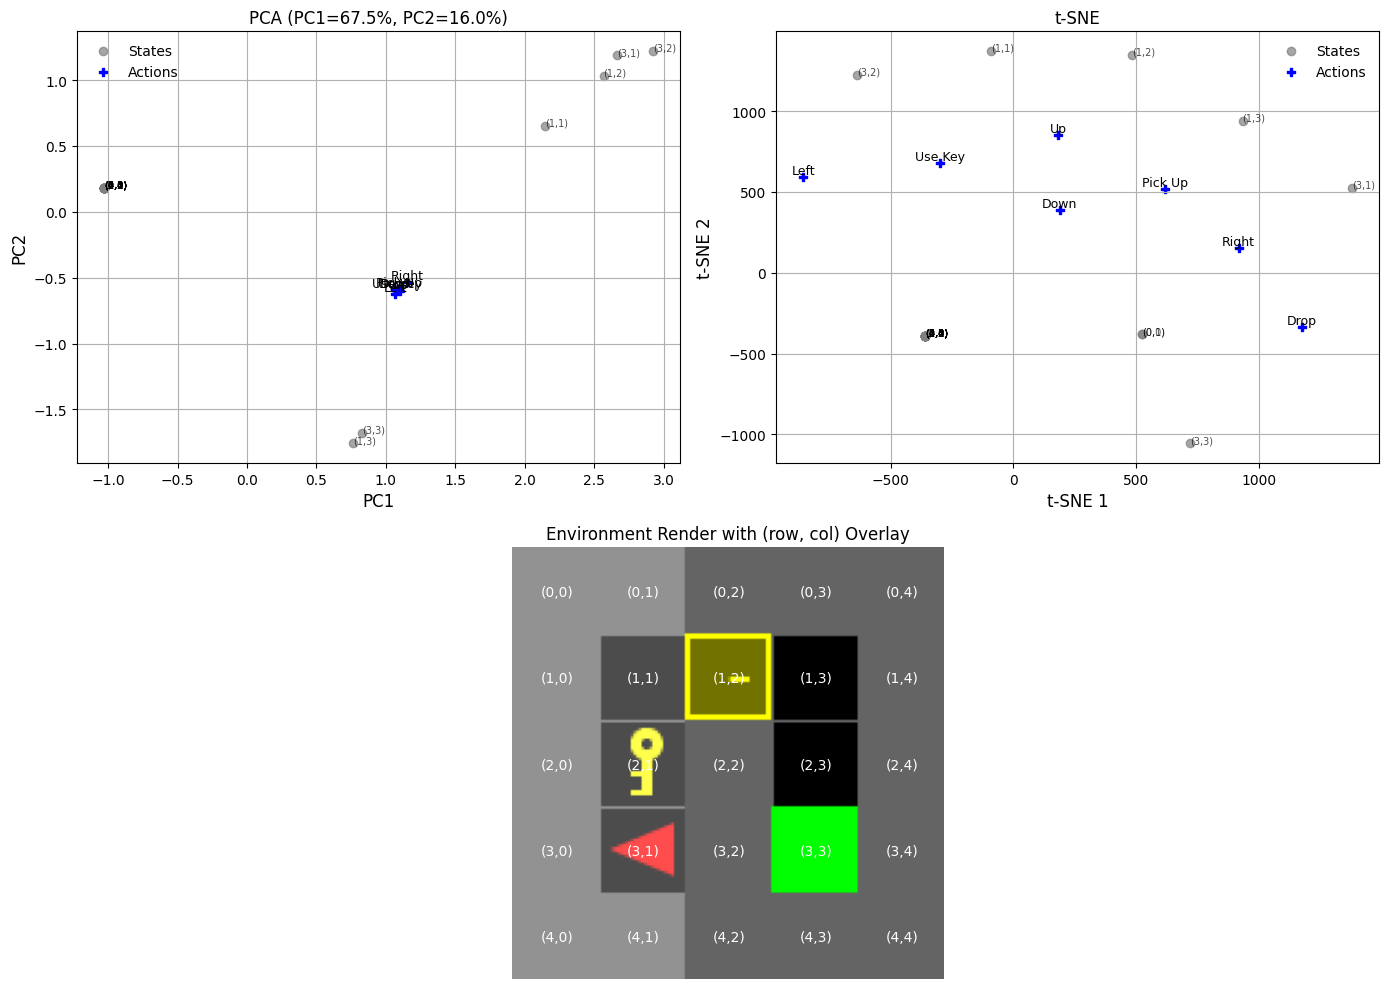

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gymnasium as gym
from minigrid.wrappers import FullyObsWrapper

# --- Assume these variables are already defined ---
# state_embeddings: shape (num_states, embed_dim)
# action_embeddings: shape (num_actions, embed_dim)
# coords: list of (row, col) for each state (length == num_states)

# For demonstration, here's some dummy data:
# (Remove these and use your actual variables)
coords = [(i // 5, i % 5) for i in range(25)]
action_labels = ["Left", "Right", "Down", "Up", "Pick Up", "Use Key", "Drop"]

# --- Dimensionality Reduction (PCA and t-SNE) ---
combined = np.vstack([state_embeddings, action_embeddings])

# PCA
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=25)
combined_tsne = tsne.fit_transform(combined)
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Create the Figure with GridSpec ---
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top left: PCA plot
ax_pca = fig.add_subplot(gs[0, 0])
ax_pca.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')
ax_pca.scatter(pca_actions[:, 0], pca_actions[:, 1], color='blue', marker='P', label='Actions')
for i, (r, c) in enumerate(coords):
    x, y = pca_states[i]
    ax_pca.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    ax_pca.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0]*100, var_ratio[1]*100
ax_pca.set_title(f"PCA (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.grid(True)
ax_pca.legend()

# Top right: t-SNE plot
ax_tsne = fig.add_subplot(gs[0, 1])
ax_tsne.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')
ax_tsne.scatter(tsne_actions[:, 0], tsne_actions[:, 1], color='blue', marker='P', label='Actions')
for i, (r, c) in enumerate(coords):
    x, y = tsne_states[i]
    ax_tsne.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    ax_tsne.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
ax_tsne.set_title("t-SNE")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")
#ax_tsne.set_ylim([-50,50])

ax_tsne.grid(True)
ax_tsne.legend()

# Bottom row: Environment render with (row, col) overlay
ax_env = fig.add_subplot(gs[1, :])
# Create a fully observed environment
env = gym.make("MiniGrid-DoorKey-5x5-v0", render_mode="rgb_array")
env = FullyObsWrapper(env)
obs = env.reset(seed=0)
img = env.render()  # Typically a 160x160x3 image for a 5x5 grid

ax_env.imshow(img)
ax_env.axis('off')
# Assume each tile is of equal size (e.g., 160/5 = 32 pixels)
tile_size = img.shape[0] // 5
for r in range(5):
    for c in range(5):
        x = c * tile_size + tile_size // 2
        y = r * tile_size + tile_size // 2
        ax_env.text(x, y, f"({r},{c})", color="white",
                    ha="center", va="center", fontsize=10)
ax_env.set_title("Environment Render with (row, col) Overlay")

plt.tight_layout()
plt.show()

In [26]:
import gymnasium as gym

# --- Environment Functions ---
TRAIN_SEEDS = list(range(12))  # 12 train seeds
TEST_SEEDS = list(range(20, 32))  # 12 test seeds


for seed in TRAIN_SEEDS:
    env = gym.make("MiniGrid-DoorKey-8x8", render_mode="rgb_array")
    out, _ = env.reset(seed=TRAIN_SEEDS[seed])
    print(out['mission'])

use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal
use the key to open the door and then get to the goal


/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `MiniGrid-DoorKey-8x8-v0` instead of the unversioned environment `MiniGrid-DoorKey-8x8`.
  logger.warn(


In [29]:
out.keys()

dict_keys(['image', 'direction', 'mission'])